# Librerias


In [1]:
!python -c "import SimpleITK" || pip install --upgrade --pre SimpleITK --find-links https://github.com/SimpleITK/SimpleITK/releases/tag/latest --progress-bar off -q
!python -c "import matplotlib" || pip install --progress-bar off -q matplotlib
!python -c "import radiomics" || pip install --progress-bar off -q pyradiomics
!python -c "import yaml" || pip install --progress-bar off -q pyyaml
!python -c "import pandas" || pip install --progress-bar off -q pandas

In [15]:
#import yaml
import os
import pandas as pd
import csv
from pathlib import Path
import re
import matplotlib.pyplot as plt
import matplotlib as mpl  
import seaborn as sns
import numpy as np
from radiomics import featureextractor
import concurrent.futures
import SimpleITK as sitk
import monai



# Archivos csv con rutas y params


In [3]:
csv_path = '/mnt/datalake/openmind/MedP-Midas/data/filtered_midas900_t2w.csv'
param_path = '/mnt/datalake/openmind/MedP-Midas/src/radiomics/Params.yaml'
input_df = pd.read_csv(csv_path)

## Image size

In [4]:
os.makedirs("/mnt/datalake/openmind/MedP-Midas/data/datos_intermedios", exist_ok=True)


rows = []

for idx, ruta in enumerate(input_df['Image']):
    try:
        img = sitk.ReadImage(ruta)
        w, h, d = img.GetSize()
        rows.append({
            "ID": input_df.loc[idx, 'ID'],
            "image_width": w,
            "image_height": h,
            "image_depth": d
        })
    except Exception as e:
        print(f"Error con la imagen {ruta}: {e}")

df = pd.DataFrame(rows)
df.to_csv("/mnt/datalake/openmind/MedP-Midas/data/datos_intermedios/image_dimensions.csv", index=False)
df.head()

,ID,image_width,image_height,image_depth
0,s_10223,512,512,12
1,s_10095,512,512,12
2,s_10087,512,512,12
3,s_10168,512,512,12
4,s_10067,512,512,14


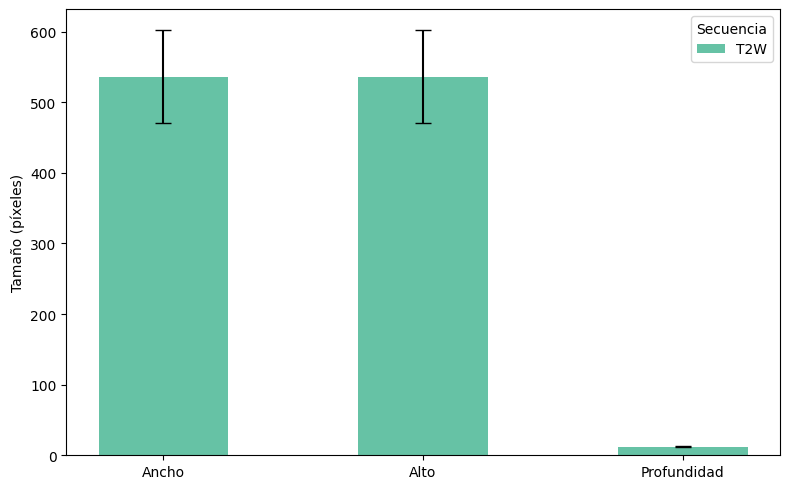

In [5]:
csv_path_dimensions = Path("/mnt/datalake/openmind/MedP-Midas/data/datos_intermedios/image_dimensions.csv")
df = pd.read_csv(csv_path_dimensions)

# 2. Definir secuencias y dimensiones
secuencias = ["t2w"]
dimensiones = ["width", "height", "depth"]
col_tpl = "image_{dim}"

# 3. Calcular medias y desviaciones
# Calcular medias y desviaciones para t2w
medias = [df[col_tpl.format(dim=dim)].mean() for dim in dimensiones]
desv   = [df[col_tpl.format(dim=dim)].std()  for dim in dimensiones]


# 4. Configurar la paleta color-blind-friendly
palette = sns.color_palette("Set2", n_colors=1)
colores = {"t2w": palette[0]}

# ─────────────────────────────────────────────────────────
# 5. Dibujar las barras
x = np.arange(len(dimensiones))   
ancho   = 0.5

fig, ax = plt.subplots(figsize=(8, 5))

ax.bar(
    x,
    medias,
    ancho,
    yerr=desv,
    capsize=6,
    label="T2W",
    color=colores["t2w"]
)

# 6. Etiquetas en castellano
ax.set_xticks(x)
ax.set_xticklabels(['Ancho', 'Alto', 'Profundidad'])
ax.set_ylabel('Tamaño (píxeles)')
ax.legend(title='Secuencia')

fig.tight_layout()
# fig.savefig("results/tamaño_t2w.png", dpi=300, bbox_inches="tight")
plt.show()

## Spacing image


In [6]:
input_df = pd.read_csv(csv_path)
rows = []

for idx, ruta in enumerate(input_df['Image']):
    try:
        img = sitk.ReadImage(ruta)
        esp_x, esp_y, esp_z = img.GetSpacing()
        rows.append({
            "ID": input_df.loc[idx, 'ID'],
            "t2w_spac_x": esp_x,
            "t2w_spac_y": esp_y,
            "t2w_spac_z": esp_z
        })
    except Exception as e:
        print(f"Error con la imagen {ruta}: {e}")

df = pd.DataFrame(rows)
df.to_csv("/mnt/datalake/openmind/MedP-Midas/data/datos_intermedios/image_spacing.csv", index=False)
df.head()

,ID,t2w_spac_x,t2w_spac_y,t2w_spac_z
0,s_10223,0.644531,0.644526,5.999982
1,s_10095,0.585938,0.585943,5.499995
2,s_10087,0.585938,0.585934,5.500022
3,s_10168,0.585938,0.585938,5.800040
4,s_10067,0.585938,0.585938,5.500000


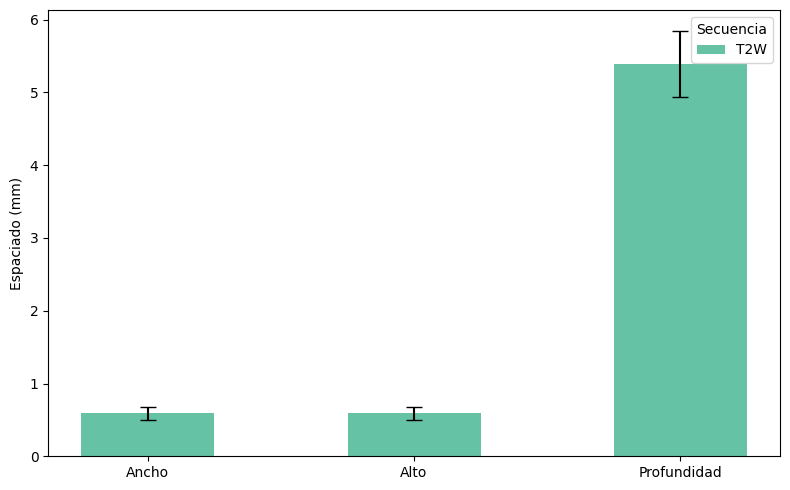

[np.float64(0.5900618276835485), np.float64(0.5900616403902924), np.float64(5.386819155146387)]


In [7]:
# 1. Cargar CSV de espaciados
df = pd.read_csv("/mnt/datalake/openmind/MedP-Midas/data/datos_intermedios/image_spacing.csv")

# 2. Definir ejes (solo t2w)
ejes = ["spac_x", "spac_y", "spac_z"]
col_tpl = "t2w_{eje}"

# 3. Calcular medias y desviaciones para t2w
medias = [df[col_tpl.format(eje=eje)].mean() for eje in ejes]
desv   = [df[col_tpl.format(eje=eje)].std()  for eje in ejes]

# 4. Paleta colorblind-friendly
color = sns.color_palette("Set2", n_colors=1)[0]

# 5. Dibujar barras
x = np.arange(len(ejes))
ancho = 0.5

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(
    x,
    medias,
    ancho,
    yerr=desv,
    capsize=6,
    label="T2W",
    color=color
)

# 6. Etiquetas en castellano
ax.set_xticks(x)
ax.set_xticklabels(['Ancho', 'Alto', 'Profundidad'])
ax.set_ylabel('Espaciado (mm)')
ax.legend(title='Secuencia')

fig.tight_layout()
# fig.savefig("results/espaciado_t2w.png", dpi=300, bbox_inches="tight")
plt.show()
print(medias)

## Label + image visualization


[0 1 2 3 4 5 6 7 8]


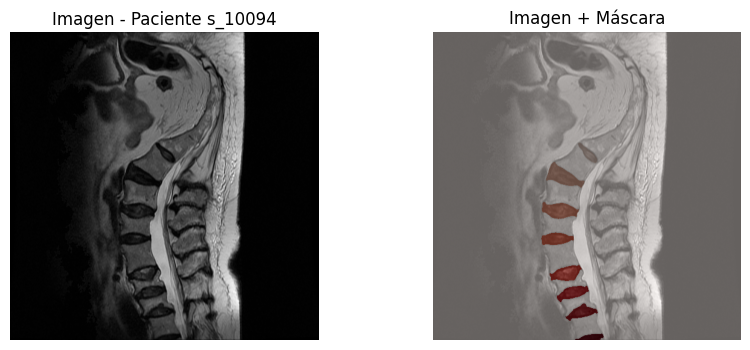

In [14]:
# Cambia el índice para ver diferentes pacientes
for idx, row in input_df.iterrows():
    if idx == 5:  # Cambia el índice para ver diferentes pacientes
        
        image_path = row["Image"]
        mask_path = row["Mask"]

        # Leer imagen y máscara
        image = sitk.ReadImage(image_path)
        mask = sitk.ReadImage(mask_path)

        # Convertir a array numpy
        image_np = sitk.GetArrayFromImage(image)
        mask_np = sitk.GetArrayFromImage(mask)
        print(np.unique(mask_np))

        # Seleccionar un corte central
        slice_idx = image_np.shape[0] // 2

        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(image_np[slice_idx], cmap="gray")
        plt.title(f"Imagen - Paciente {row['ID']}")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(image_np[slice_idx], cmap="gray")
        plt.imshow(mask_np[slice_idx], alpha=0.4, cmap="Reds")
        plt.title("Imagen + Máscara")
        plt.axis("off")

        plt.show()
        

## MONAI visualization specific case

In [32]:
image_path = input_df["Image"][1]
mask_path = input_df["Mask"][1]

image = monai.transforms.LoadImage(image_only=True, ensure_channel_first=True)(image_path)
label = monai.transforms.LoadImage(image_only=True, ensure_channel_first=True)(mask_path)
label[label > 5] = 0
print(f"Imagen: {image.shape}, Máscara: {label.shape}")

Imagen: torch.Size([1, 512, 512, 12]), Máscara: torch.Size([1, 512, 512, 12])


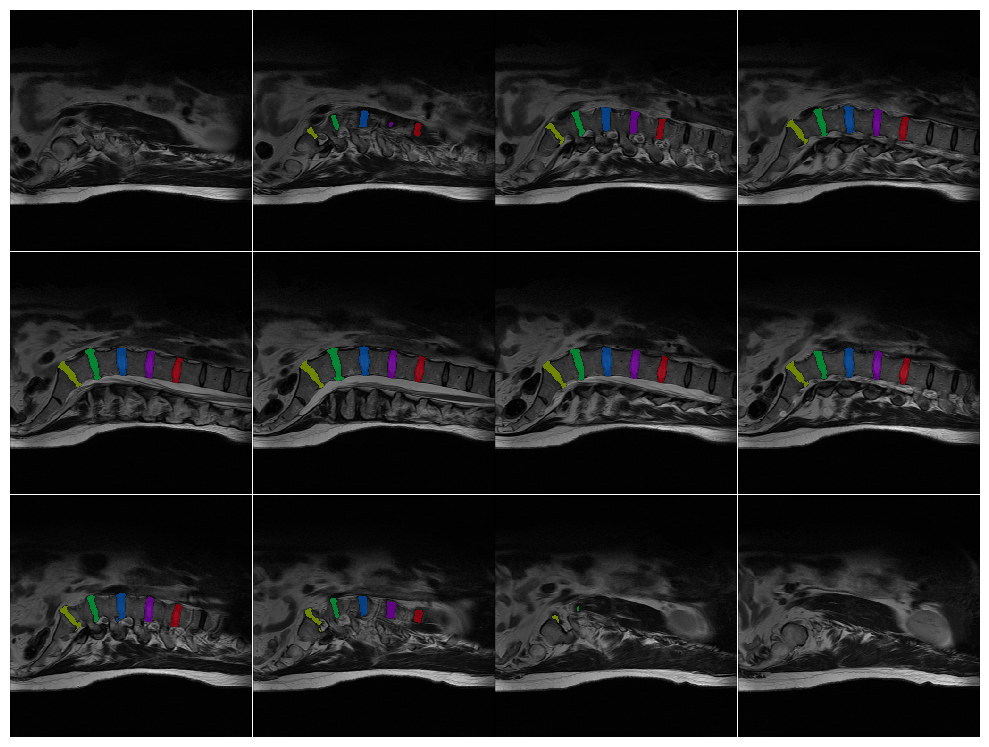

In [34]:

blended = monai.visualize.utils.blend_images(image, label)
monai.visualize.matshow3d(blended, frame_dim=-1, channel_dim=0, show=True)
plt.show()

## Get bin width

In [ ]:
input_df = pd.read_csv(csv_path)
ranges_t2w = []

# Configuración del extractor solo para t2w
extractor = featureextractor.RadiomicsFeatureExtractor("/mnt/datalake/openmind/MedP-Midas/src/radiomics/Params.yaml")
extractor.disableAllFeatures()
extractor.enableFeaturesByName(firstorder=["Range"])

# 3. Lista para almacenar los rangos
ranges_t2w = []

def process_file(image_path, extractor):
    """
    Procesa una imagen dada su ruta y extractor correspondiente.
    Retorna el valor de 'original_firstorder_Range' o None en caso de error.
    """
    try:
        image = sitk.ReadImage(image_path)
        image_array = sitk.GetArrayFromImage(image)
        mask_array = np.ones_like(image_array, dtype=np.uint8)
        mask_array[0, 0, 0] = 0  # Así hay fondo y ROI
        mask = sitk.GetImageFromArray(mask_array)
        mask.CopyInformation(image)
        result = extractor.execute(image, mask, label=1)
        return result.get("original_firstorder_Range", None)
    except Exception as e:
        print(f"Error procesando {image_path}: {e}")
        return None

# Procesar todas las imágenes T2w usando enumerate para mantener tu estilo
for idx, ruta in enumerate(input_df['Image']):
    valor = process_file(ruta, extractor)
    if valor is not None:
        ranges_t2w.append(valor)

# Mostrar estadísticas
if ranges_t2w:
    ranges_array = np.array(ranges_t2w)
    print("Estadísticas de firstorder:Range para T2W:")
    print(f"  Media: {ranges_array.mean():.2f}")
    print(f"  Mínimo: {ranges_array.min():.2f}")
    print(f"  Máximo: {ranges_array.max():.2f}")
    for tb in [16, 32, 64, 128]:
        print(f"  Para {tb} bins: binWidth = {ranges_array.mean()/tb:.2f}")
else:
    print("No se encontraron imágenes o no se pudo extraer 'firstorder:Range'.")